# Training the Asteroid model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import ngboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

In [2]:
from pathlib import Path
Path("tables_for_analysis").mkdir(exist_ok=True)

In [ ]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
	solar_system_synthetic_theory=pickle.load(fi)

In [ ]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
	solar_system_synthetic_theory.masses,
	solar_system_synthetic_theory.semi_major_axes,
	solar_system_synthetic_theory.omega_vector,
	[truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
	[truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [6]:
merged_df = pd.read_csv("merged_elements.csv")

/tmp/ipykernel_1717898/4206613897.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("merged_elements.csv")


In [6]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])
merged_df["s0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[1])

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/celmech/disturbing_function.py:1081: SyntaxWarning: invalid escape sequence '\e'
  """


KeyboardInterrupt: 

In [7]:
merged_df["prope_h"] = np.abs(merged_df["prope_h"])
merged_df["propsini_h"] = np.abs(merged_df["propsini_h"])
merged_df['prope_h'] = pd.to_numeric(merged_df['prope_h'], errors='coerce')
merged_df['propsini_h'] = pd.to_numeric(merged_df['propsini_h'], errors='coerce')
merged_df['Node'] = pd.to_numeric(merged_df['Node'], errors='coerce')
merged_df['Peri.'] = pd.to_numeric(merged_df['Peri.'], errors='coerce')
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [8]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features_e = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0', 's0', 'prope_h', 'propsini_h']
features_inc = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0', 's0', 'prope_h', 'propsini_h']
data_e = merged_df[features_e]
data_inc = merged_df[features_inc]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['e']
delsini = merged_df['propsini']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

In [9]:
de = merged_df["de"]
trainX_e, testX_e, trainX_inc, testX_inc, trainY_e, testY_e, trainY_inc, testY_inc = train_test_split(data_e, data_inc, dele, delsini, test_size=0.4, random_state=42)
valX_e, testX_e, valX_inc, testX_inc, valY_e, testY_e, valY_inc, testY_inc = train_test_split(testX_e, testX_inc, testY_e, testY_inc, test_size=0.5, random_state=42)

# NGBooster training

In [ ]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor

trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)
space = {
	'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
	'minibatch_frac': hp.uniform('minibatch_frac', 0.1, 1.0),
	'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3))
}

def objective(params):
	clf = NGBRegressor(
		Dist=Normal,
		Score=LogScore,
		verbose=False,
		minibatch_frac=params['minibatch_frac'],
		n_estimators=200,
		learning_rate=params['learning_rate'],
		Base=DecisionTreeRegressor(max_depth=int(params['max_depth']))
	)
	
	clf.fit(trainX, trainY)    
	preds = clf.pred_dist(testX)
	mu = preds.loc
	rmse = np.sqrt(np.mean((testY-mu)**2))

	return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
start = time.time()

best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Best hyperparameters:", best)
print("Optimization Time: %.2f seconds" % (end - start))

  0%|          | 0/10 [00:04<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [58]:
best = {'learning_rate': 0.04034673661098748, 'max_depth': 13, 'minibatch_frac': 0.732521917705310}

In [ ]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as n

SyntaxError: invalid syntax (3600382070.py, line 9)

In [ ]:
final_model = NGBRegressor(
	# Dist=Normal,
	# Score=LogScore,
	# n_estimators=500,
	# natural_gradient=True,
	minibatch_frac=best['minibatch_frac'], # 1
	learning_rate=best['learning_rate'], # 0.1
	Base=DecisionTreeRegressor(max_depth=best['max_depth']) # 6
)

final_model.fit(trainX, trainY)

[iter 0] loss=-1.9790 val_loss=0.0000 scale=1.0000 norm=0.4494


KeyboardInterrupt: 

In [ ]:
ngb = Path("models/best_model.ngb")
with ngb.open("wb") as f:
	pickle.dump(final_model, f)

## Load the model (no running)

In [3]:
import pickle
from pathlib import Path

ngb_e = Path("models/best_model_ecc_val_2.ngb")
with ngb_e.open("rb") as f:
	final_model_e = pickle.load(f)
	
ngb_inc = Path("models/best_model_inc_val_2.ngb")
with ngb_inc.open("rb") as f:
	final_model_inc = pickle.load(f)

In [10]:
trainX_e, testX_e, trainX_inc, testX_inc, trainY_e, testY_e, trainY_inc, testY_inc = train_test_split(data_e, data_inc, dele, delsini, test_size=0.4, random_state=42)

In [11]:
pred_dist = final_model_e.pred_dist(testX_e)

pred_e = pred_dist.loc
std_e = pred_dist.scale

pred_dist = final_model_inc.pred_dist(testX_inc)

pred_inc = pred_dist.loc
std_inc = pred_dist.scale

In [12]:
test_indices = testX_e.index.tolist()

In [13]:
df_ngb = pd.DataFrame(list(zip(testY_e, pred_e, std_e, testY_inc, pred_inc, std_inc)), columns = ["actual_dele", "pred_e", "error_e", "actual_delsini", "pred_inc", "error_inc"])
df_ngb = df_ngb.reset_index(drop=True)
test_data = merged_df.loc[test_indices].reset_index(drop=True)

df_ngb["Des'n"] = test_data["Des'n"]
df_ngb["e"] = test_data["e"]
df_ngb["Incl."] = test_data["Incl."]
df_ngb["propa"] = test_data["propa"]
df_ngb["prope"] = test_data["prope"]
df_ngb["prope_h"] = test_data["prope_h"]
df_ngb["propsini"] = test_data["propsini"]
df_ngb["propsini_h"] = test_data["propsini_h"]
df_ngb["da"] = test_data["da"]
df_ngb["dsini"] = test_data["dsini"]
df_ngb["de"] = test_data["de"]
df_ngb.to_csv("tables_for_analysis/NGBooster_result.csv")

In [14]:
df_ngb

,actual_dele,pred_e,error_e,actual_delsini,pred_inc,error_inc,Des'n,e,Incl.,propa,prope,prope_h,propsini,propsini_h,da,dsini,de
0,0.000067,-0.025122,0.004303,-0.002757,-0.002200,4.535878,h2457,0.023071,5.98580,2.737673,0.023138,0.015653,0.101525,0.050919,2.000000e-08,0.001200,0.005300
1,-0.006115,0.024522,0.003416,-0.013262,-0.108124,37.488099,K17Q48R,0.180419,12.42983,2.697389,0.174304,0.185447,0.201982,0.105127,2.900000e-07,0.000002,0.000015
2,0.027774,0.056729,0.004504,0.023242,0.122909,313.489585,v9954,0.191661,9.62640,2.677371,0.219435,0.236699,0.190465,0.085482,5.900000e-06,0.000054,0.000110
3,-0.041527,-0.015000,0.007293,-0.018113,-0.079601,7.304472,K17P54P,0.175703,5.61772,3.140491,0.134176,0.133146,0.079778,0.043310,1.600000e-05,0.000006,0.000013
4,-0.038788,-0.031374,0.010828,-0.003989,0.063477,1.292528,O8107,0.262128,6.03518,2.224343,0.223340,0.211611,0.101150,0.045614,9.700000e-03,0.001800,0.005600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499525,0.047851,0.036085,0.003703,0.024058,0.106935,4.560793,K14DG5A,0.094050,4.86325,3.076732,0.141901,0.126507,0.108836,0.047778,9.900000e-04,0.002100,0.006200
499526,-0.004041,0.000170,0.014334,-0.008182,-0.028993,0.963137,K10U99D,0.032581,4.39191,2.649896,0.028540,0.030654,0.068396,0.037423,2.100000e-06,0.000089,0.000110
499527,0.005529,-0.014149,0.003139,0.003351,0.048979,0.350643,R9302,0.081338,3.22703,2.888156,0.086867,0.086330,0.059644,0.027788,3.200000e-06,0.000014,0.000007
499528,-0.016498,0.027776,0.009405,0.012672,0.083554,1.704331,K08AD1S,0.089252,3.71427,2.541128,0.072754,0.075434,0.077453,0.033078,2.800000e-06,0.000560,0.006500


# Neural Network

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # graphics card
device = torch.device("mps" if torch.mps.is_available() else "cpu") # macos
print(device)

AttributeError: module 'torch.mps' has no attribute 'is_available'

In [ ]:
class MultiOutputNN(nn.Module):
	def __init__(self, input_dim):
		super().__init__()
		activation = nn.Tanh
		self.f = nn.Sequential(
			nn.Linear(input_dim, 10),
			activation(),
			nn.Linear(10, 15),
			activation(),
			nn.Linear(15, 8),
			activation(),
			nn.Linear(8, 4),
			activation(), 
			nn.Linear(4, 2),
			activation(), 
		)
		# self.f = nn.Sequential(
		# 	nn.Linear(input_dim, 4),
		# 	activation(), 
		# 	nn.Linear(4, 2),
		# 	activation()
		# )

	def forward(self, x):
		return self.f(x)

class MultiOutputML:
	"""
	Neural Network learning model to predict the proper elements from osculating and linear proper 
	elements derived from Nesvorny 2024 paper
	"""

	def __init__(self, device):
		self.model = None
		self.device = device
		self.random_state = 42
		self.best_params = None


	def combined_loss(self, outputs, true_proper, kl_weight=0.05, mse_weight=1.0):
		mean_pred = outputs[:, 0]
		log_std_pred = outputs[:, 1]
		std_pred = torch.exp(log_std_pred)/10

		true_std = 0.1
		true_mean = 0.0

		# KL Divergence
		kl_div = (
			torch.log(true_std / std_pred) +
			(std_pred**2 + (mean_pred - true_mean)**2) / (2 * true_std**2) -
			0.5
		)
		kl_loss = kl_div.mean()

		# Sample from predicted distribution and compute RMSE
		e_proper_guess = mean_pred + torch.randn_like(std_pred) * std_pred
		# mse_loss = ((e_proper_guess - true_proper)**2).mean()
		mse_loss = torch.nn.L1Loss()(e_proper_guess, true_proper)

		return kl_weight * kl_loss + mse_weight * mse_loss

	# def objective(self, params):
	# 	input_dim = self.trainX.shape[1]
	# 	model = MultiOutputNN(input_dim).to(self.device)
	# 	optimizer = optim.Adam(model.parameters(), lr=0.001)
	# 	loss_func = self.combined_loss

	# 	X_train_tensor = torch.tensor(self.X, dtype=torch.float32).to(self.device)
	# 	y_train_tensor = torch.tensor(self.y, dtype=torch.float32).to(self.device)
	# 	for epoch in range(100):
	# 		model.train()
	# 		optimizer.zero_grad()
	# 		outputs = model(X_train_tensor)
	# 		loss = loss_func(outputs, y_train_tensor)
	# 		loss.backward()
	# 		optimizer.step()

	# 	# Evaluation
	# 	model.eval()
	# 	with torch.no_grad():
	# 		X_test_tensor = torch.tensor(self.testX, dtype=torch.float32).to(self.device)
	# 		y_test_tensor = torch.tensor(self.testy, dtype=torch.float32).to(self.device)
	# 		pred = model(X_test_tensor)
	# 		test_loss = loss_func(pred, y_test_tensor).item()

	# 	return {'loss': test_loss, 'status': STATUS_OK}
	
	# def optimize_hyperparameters(self, X, y, max_evals=10):
	# 	# self.trainX, self.testX, self.trainy, self.testy = train_test_split(
	# 	# 	X, y, test_size=0.2, random_state=self.random_state
	# 	# )
	# 	trials = Trials()
	# 	import time
	# 	start = time.time()
	# 	self.best = fmin(
	# 		fn=self.objective,
	# 		space=self.space,
	# 		algo=tpe.suggest,
	# 		max_evals=max_evals,
	# 		trials=trials,
	# 		rstate=np.random.default_rng(self.random_state)
	# 	)
	# 	end = time.time()
	# 	print("Optimization Time: %f seconds", (end  -start))

	def training(self, X, y, epochs=300, batch_size=64, lr=0.001):
		self.X = X
		self.y = y

		input_dim = X.shape[1]
		self.model = MultiOutputNN(input_dim).to(self.device)
		optimizer = optim.Adam(self.model.parameters(), lr=lr)
		criterion = self.combined_loss

		X_tensor = torch.tensor(X, dtype=torch.float32)
		y_tensor = torch.tensor(y, dtype=torch.float32)

		dataset = TensorDataset(X_tensor, y_tensor)
		training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

		self.loss_list = []

		for epoch in tqdm(range(epochs), desc="Training"):
			self.model.train()
			epoch_loss = 0

			for batch_X, batch_y in training_loader:
				batch_X = batch_X.to(self.device)
				batch_y = batch_y.to(self.device)

				optimizer.zero_grad()
				outputs = self.model(batch_X)
				loss = criterion(outputs, batch_y)
				loss.backward()
				optimizer.step()

				epoch_loss += loss.item()

			avg_loss = epoch_loss / len(training_loader)
			self.loss_list.append(avg_loss)

		return self.loss_list, self.model

	def predict(self, X):
		self.model.eval()
		with torch.no_grad():
			X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
			pred = self.model(X_tensor).cpu().numpy()
			pred_mean = pred[:, 0]
			pred_std = np.exp(pred[:, 1])/10
			return pred_mean, pred_std


In [8]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.4, random_state=42)
scalar = StandardScaler()
scalar.fit_transform(trainX)
trainX = scalar.transform(trainX)
testX = scalar.transform(testX)

In [ ]:
model = MultiOutputML(device)

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Training: 100%|██████████| 300/300 [17:53<00:00,  3.58s/it]


In [ ]:
nn = Path("models/best_model.nn")
with nn.open("wb") as f:
	pickle.dump(final_model, f)

In [ ]:
nn = Path("models/best_model.nn")
with nn.open("rb") as f:
	model = pickle.load(f)

In [17]:
loss_list, trained_model = model.training(trainX, trainY.to_numpy(), batch_size=2048*64)

AttributeError: 'NGBRegressor' object has no attribute 'training'

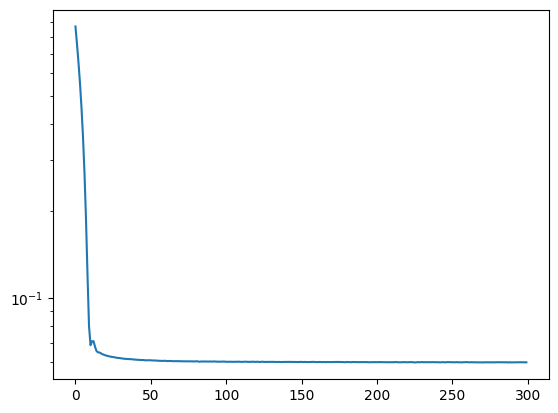

In [11]:
plt.semilogy(model.loss_list)

In [14]:
pred_nn, std_nn = model.predict(testX)
plt.scatter(np.abs(testY - pred_nn), std_nn, alpha=0.1)

ValueError: too many values to unpack (expected 2)

In [ ]:
df_nn = pd.DataFrame(
	list(zip(testY, pred_nn, std_nn)),
	columns=["actual_dele", "pred_nn", "std_nn"]
)
df_nn.to_csv("tables_for_analysis/Neural_Network_results")

array([-0.00836096,  0.01456548, -0.02281791, ...,  0.00335555,
        0.03355795, -0.01788718], dtype=float32)

In [ ]:
import itertools
import numpy as np

FN_list = [] # Do not need to integrate but predict as need to integrate
FP_list = [] # Need to integrate but predict as don't need to integrate
TN_list = [] # Do not need to integrate and predict as need to integrate
TP_list = [] # Need to integrate and predict as need to integrate

actual_thresholds = 0.05
pred_thresholds = np.linspace(0, 0.2, 1000)
actual_val = testY.to_numpy()

tpr = []
fpr = []

for pred_thres in tqdm(pred_thresholds):
	FN = FP = TN = TP = 0

	percentage_error = np.abs(actual_val- pred) / (np.abs(actual_val) + 1e-8)

	pct_err_gt_thresh = percentage_error > actual_thresholds
	std_gt_pred_thresh = std > pred_thres

	TP = (pct_err_gt_thresh & std_gt_pred_thresh).sum()
	FP = ((~pct_err_gt_thresh) & std_gt_pred_thresh).sum()
	FN = (pct_err_gt_thresh & (~std_gt_pred_thresh)).sum()
	TN = ((~pct_err_gt_thresh) & (~std_gt_pred_thresh)).sum()
	
	if (TP + FN) > 0 and (FP + TN) > 0:
		tpr.append(TP / (TP + FN))
		fpr.append(FP / (FP + TN))


100%|██████████| 1000/1000 [00:01<00:00, 513.32it/s]


In [29]:
fpr = np.array(fpr)
tpr = np.array(tpr)
sorted_indices = np.argsort(fpr)
fpr = fpr[sorted_indices]
tpr = tpr[sorted_indices]

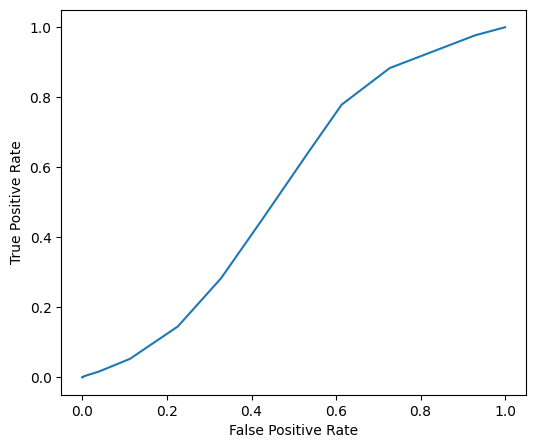

In [30]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [27]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)
print(f"the AUC score is {auc_score}")

the AUC score is 0.539865214137008


# XGBooster training

In [ ]:
dtrain_e = xgb.DMatrix(trainX_e, trainY_e)
dval_e = xgb.DMatrix(valX_e, valY_e)
dtest_e = xgb.DMatrix(testX_e, testY_e)
dtrain_inc = xgb.DMatrix(trainX_inc, trainY_inc)
dval_inc = xgb.DMatrix(valX_inc, valY_inc)
dtest_inc = xgb.DMatrix(testX_inc, testY_inc)

In [53]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dval_e, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [54]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                 
0.01066788652671646                                    
+/-                                                    
5.339669385661962e-05                                  
SCORE:                                                                           
0.010667240297115917                                                             
+/-                                                                              
5.416097281989622e-05                                                            
SCORE:                                                                           
0.009883791434972726                                                             
+/-                                                                              
6.489105733425376e-05                                                            
SCORE:                                                                             
0.009620541212921122                

In [55]:
best

{'x_max_depth': np.float64(5.0),
 'x_min_child': np.float64(1.318791295842831),
 'x_subsample': np.float64(0.9393021695149961)}

In [56]:
model = XGBRegressor(learning_rate = 0.05, 
                         max_depth = 5, 
                         subsample = 0.9393021695149961,
                         min_child_weight = 1.318791295842831)

score = xgb.cv(model.get_xgb_params(), dtrain_inc, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=500)

[0]	train-rmse:0.01573+0.00001	test-rmse:0.01573+0.00004
[1]	train-rmse:0.01523+0.00001	test-rmse:0.01523+0.00004
[2]	train-rmse:0.01476+0.00001	test-rmse:0.01477+0.00004
[3]	train-rmse:0.01433+0.00001	test-rmse:0.01433+0.00004
[4]	train-rmse:0.01392+0.00001	test-rmse:0.01393+0.00004
[5]	train-rmse:0.01354+0.00001	test-rmse:0.01355+0.00004
[6]	train-rmse:0.01318+0.00001	test-rmse:0.01319+0.00004
[7]	train-rmse:0.01285+0.00001	test-rmse:0.01286+0.00004
[8]	train-rmse:0.01254+0.00001	test-rmse:0.01255+0.00004
[9]	train-rmse:0.01225+0.00001	test-rmse:0.01226+0.00004
[10]	train-rmse:0.01198+0.00001	test-rmse:0.01199+0.00005
[11]	train-rmse:0.01173+0.00001	test-rmse:0.01174+0.00005
[12]	train-rmse:0.01149+0.00001	test-rmse:0.01151+0.00005
[13]	train-rmse:0.01127+0.00001	test-rmse:0.01129+0.00005
[14]	train-rmse:0.01107+0.00001	test-rmse:0.01109+0.00005
[15]	train-rmse:0.01088+0.00001	test-rmse:0.01090+0.00005
[16]	train-rmse:0.01070+0.00001	test-rmse:0.01073+0.00005
[17]	train-rmse:0.01054+

In [59]:
%%time
model= xgb.train(dtrain=dtrain_inc, params=model.get_params(), num_boost_round=2000)

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:39:09] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 10h 56min 7s, sys: 19.3 s, total: 10h 56min 26s
Wall time: 11min 46s


In [60]:
%%time
pred_inc = model.predict(dtest_inc)

CPU times: user 12.3 s, sys: 32 μs, total: 12.3 s
Wall time: 263 ms


In [ ]:
def custom_loss_func(preds, dtrain, uncertainty):
	prope = dtrain.get_label()
	weights = dtrain.get_weight()
	grad = 2 * (preds - prope) * weights
	hess = 2 * weights
	return grad, hess

params = {
	'learning_rate': 0.05,
	'max_depth': 6,
	'subsample': 0.946,
	'min_child_weight': 29.03,
	# Do NOT include 'objective' when using custom loss function
}

score = xgb.cv(
	params=params,
	dtrain=dtrain,
	num_boost_round=500,
	nfold=5,
	verbose_eval=True,
	obj=custom_loss_func  # Custom objective function goes here
)

[0]	train-rmse:0.47955+0.00082	test-rmse:0.47982+0.00330
[1]	train-rmse:0.45558+0.00078	test-rmse:0.45580+0.00314
[2]	train-rmse:0.43280+0.00074	test-rmse:0.43298+0.00298
[3]	train-rmse:0.41116+0.00069	test-rmse:0.41135+0.00288
[4]	train-rmse:0.39060+0.00066	test-rmse:0.39078+0.00275
[5]	train-rmse:0.37107+0.00063	test-rmse:0.37124+0.00262
[6]	train-rmse:0.35252+0.00060	test-rmse:0.35268+0.00252
[7]	train-rmse:0.33490+0.00057	test-rmse:0.33504+0.00242
[8]	train-rmse:0.31816+0.00054	test-rmse:0.31826+0.00232
[9]	train-rmse:0.30224+0.00052	test-rmse:0.30232+0.00222
[10]	train-rmse:0.28714+0.00050	test-rmse:0.28718+0.00215
[11]	train-rmse:0.27279+0.00047	test-rmse:0.27283+0.00208
[12]	train-rmse:0.25915+0.00045	test-rmse:0.25919+0.00201
[13]	train-rmse:0.24620+0.00043	test-rmse:0.24619+0.00193
[14]	train-rmse:0.23390+0.00041	test-rmse:0.23388+0.00188
[15]	train-rmse:0.22220+0.00040	test-rmse:0.22218+0.00183
[16]	train-rmse:0.21109+0.00038	test-rmse:0.21105+0.00178
[17]	train-rmse:0.20055+

In [31]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model1= xgb.train(dtrain=dtrain, params=params, num_boost_round=2000, obj=custom_loss_func)

pred1 = model1.predict(dtest)

In [26]:
percent_error = np.abs(((testY - pred1) / testY) * 100)
percent_error = np.clip(percent_error, 0, 100)

In [ ]:
error_trainX, error_testX, error_trainY, error_testY = train_test_split(testX, percent_error, test_size=0.2, random_state=42)
dtrain_error = xgb.DMatrix(error_trainX, label=error_trainY)
dtest_error = xgb.DMatrix(error_testX, label=error_testY)

error_model = XGBRegressor(
	learning_rate=0.05,
	max_depth=6,
	subsample=0.946,
	min_child_weight=29.03
)

error_cv = xgb.cv(
	error_model.get_xgb_params(),
	dtrain_error,
	nfold=5,
	metrics="rmse",
	verbose_eval=True,
	num_boost_round=500
)

[0]	train-rmse:32.28806+0.01128	test-rmse:32.29124+0.04533
[1]	train-rmse:31.90242+0.00934	test-rmse:31.90821+0.04663
[2]	train-rmse:31.55101+0.00893	test-rmse:31.55856+0.04700
[3]	train-rmse:31.22015+0.00982	test-rmse:31.23087+0.04584
[4]	train-rmse:30.91731+0.01659	test-rmse:30.93108+0.04147
[5]	train-rmse:30.62429+0.01448	test-rmse:30.63983+0.04415
[6]	train-rmse:30.33888+0.01492	test-rmse:30.35725+0.03921
[7]	train-rmse:30.08195+0.01886	test-rmse:30.10387+0.03826
[8]	train-rmse:29.84564+0.01630	test-rmse:29.86894+0.03482
[9]	train-rmse:29.62989+0.01166	test-rmse:29.65597+0.04531
[10]	train-rmse:29.42652+0.01936	test-rmse:29.45488+0.03437
[11]	train-rmse:29.24368+0.02704	test-rmse:29.27456+0.04115
[12]	train-rmse:29.07214+0.01369	test-rmse:29.10428+0.03854
[13]	train-rmse:28.90165+0.02997	test-rmse:28.93651+0.04119
[14]	train-rmse:28.75113+0.03595	test-rmse:28.78864+0.03916
[15]	train-rmse:28.61608+0.03666	test-rmse:28.65489+0.03396
[16]	train-rmse:28.48495+0.03636	test-rmse:28.5257

In [28]:
final_error_model = xgb.train(dtrain=dtrain_error, params=error_model.get_params(), num_boost_round=2000)
pred2 = final_error_model.predict(dtest_error)

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:54:08] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [63]:
xgb1 = Path("models/best_model_inc.xgb")
with xgb1.open("wb") as f:
	pickle.dump(model, f)

# xgb2 = Path("models/best_model.xgb2")
# with xgb2.open("wb") as f:
# 	pickle.dump(final_error_model, f)

In [65]:
xgb1 = Path("models/best_model_inc.xgb")
with xgb1.open("rb") as f:
	model1 = pickle.load(f)

In [66]:
pred_inc = model.predict(dtest_inc)

In [ ]:
df_nn = pd.DataFrame(
	list(zip(testY, pred1, pred2)),
	columns=["actual_dele", "pred_xgb", "percent_error_xgb"]
)
df_nn.to_csv("tables_for_analysis/XGBoost_results.csv")

NameError: name 'pd' is not defined

# XGBoost with CREPES

In [ ]:
def create_custom_objective(uncertainties):
	uncertainties = np.asarray(uncertainties)
	error = 1.0 / (uncertainties ** 2 + 1e-6)

	def custom_objective(y_pred, y_true):
		grad = 2 * (y_true - y_pred) * error
		hess = 2 * error
		grad = np.clip(grad, -1e10, 1e10)
		hess = np.clip(hess, 1e-10, 1e10)
		return grad, hess
	
	return custom_objective

In [ ]:
from crepes import WrapRegressor

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(trainX, trainY,
															test_size=0.25)

# custom_obj = create_custom_objective(error_train)

model1 = XGBRegressor(learning_rate = 0.05, 
						 max_depth = 6, 
						 subsample = 0.946,
						 min_child_weight = 29.03,
						 n_estimators=2000)

reg = WrapRegressor(model1)
reg.fit(np.asarray(X_prop_train), np.asarray(y_prop_train))
values = reg.predict(np.asarray(testX))

In [ ]:
from crepes.extras import DifficultyEstimator

de_knn = DifficultyEstimator()
de_knn.fit(X=X_prop_train,
	k=5,
	scaler=True,
	y=y_prop_train,
	beta=0.5)
reg.calibrate(X_cal, y_cal, de=de_knn)

WrapRegressor(learner=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=29.03, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

In [28]:
values

array([-0.02253957, -0.00546687,  0.03357933, ...,  0.00638867,
       -0.01354484, -0.00572939], dtype=float32)

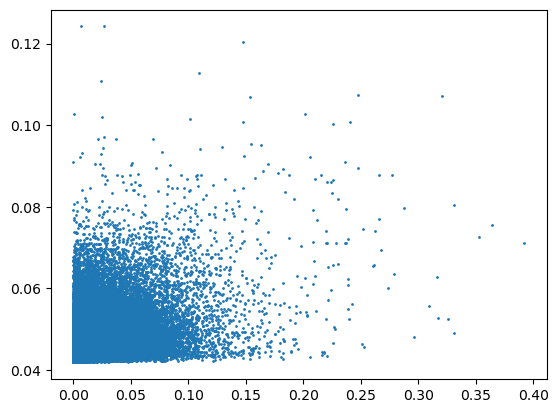

In [29]:
error_interval = reg.predict_int(testX)
error_crepe = error_interval[:, 1] - error_interval[:, 0]

frac_error = np.abs(testY - values)
plt.scatter(frac_error, error_crepe, s = 1)
# plt.ylim(0, 0.05)

In [12]:
values

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

In [ ]:
df_xgb = pd.DataFrame(
	list(zip(testY, values, error_crepe, testX["propa"])),
	columns=["actual_dele", "pred_xgb", "percent_error_xgb", "proper a"]
)

df_xgb = df_xgb.reset_index(drop=True)
test_data = merged_df.loc[test_indices].reset_index(drop=True)

df_xgb["e"] = test_data["e"]
df_xgb["propa"] = test_data["propa"]
df_xgb["prope"] = test_data["prope"]
df_xgb["propsini"] = test_data["propsini"]
df_xgb["da"] = test_data["da"]
df_xgb["dsini"] = test_data["dsini"]
df_xgb["de"] = test_data["de"]
df_xgb.to_csv("tables_for_analysis/XGBoost_crepes_results.csv")

# RMS Comparison

In [81]:
test_indices = testY_inc.index
e_nesvorny_test = merged_df.loc[test_indices, 'propsini']
e_initial_test = merged_df.loc[test_indices, 'Incl.']
e_linear_test = merged_df.loc[test_indices, 'propsini_h']

rms_nesvorny_vs_initial = np.sqrt(np.median((e_nesvorny_test - e_initial_test)**2))
rms_nesvorny_vs_linear = np. sqrt(np.median((e_nesvorny_test - e_linear_test)**2))
# rms_nesvorny_vs_nn=np.sqrt(np.median((testY-values)**2))
rms_nesvorny_vs_ml_ngb_e=np.sqrt(np.median((testY_e-pred_e)**2))
rms_nesvorny_vs_ml_ngb_inc=np.sqrt(np.median((testY_inc-pred_inc)**2))
improvement_linear_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_linear) / rms_nesvorny_vs_initial) * 100
# improvement_nn_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_nn) / rms_nesvorny_vs_initial) * 100
# improvement_nn_vs_linear = ((rms_nesvorny_vs_linear - rms_nesvorny_vs_nn) / rms_nesvorny_vs_linear) * 100
results = {
	'rms_nesvorny_vs_initial': rms_nesvorny_vs_initial,
	'rms_nesvorny_vs_linear': rms_nesvorny_vs_linear,
	# 'rms_nesvorny_vs_nn': rms_nesvorny_vs_nn,
    'rms_nesvorny_vs_ngboost_e': rms_nesvorny_vs_ml_ngb_e,
	'rms_nesvorny_vs_ngboost_inc': rms_nesvorny_vs_ml_ngb_inc,
	'improvement_linear_vs_initial_percent': improvement_linear_vs_initial,
	# 'improvement_ml_vs_initial_percent': improvement_nn_vs_initial,
	# 'improvement_ml_vs_linear_percent': improvement_nn_vs_linear
}
results

{'rms_nesvorny_vs_initial': np.float64(7.574643500053616),
 'rms_nesvorny_vs_linear': np.float64(0.06857719364872865),
 'rms_nesvorny_vs_ngboost_e': np.float64(0.0021494693654827593),
 'rms_nesvorny_vs_ngboost_inc': np.float64(0.00046660180738436875),
 'improvement_linear_vs_initial_percent': np.float64(99.09464790457474)}

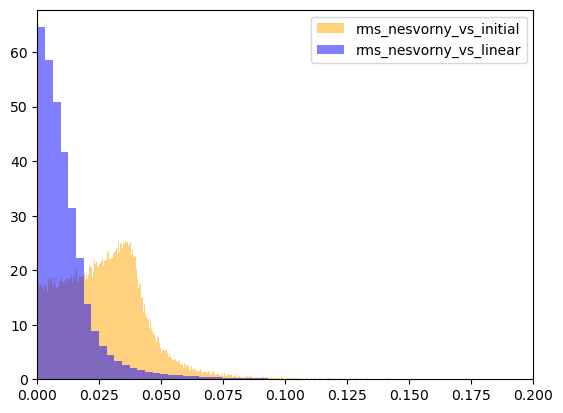

In [21]:
error_initial = np.sqrt((e_nesvorny_test - e_initial_test)**2)
error_linear = np.sqrt((e_nesvorny_test - e_linear_test)**2)
plt.hist(error_initial, bins=10000, alpha=0.5, label='rms_nesvorny_vs_initial', color = "orange", density = True)
plt.hist(error_linear, bins=10000, alpha=0.5, label='rms_nesvorny_vs_linear', color = "blue", density = True)
plt.xlim(0, 0.2)
plt.legend()

# Plots generation

## Plots for the uncertainty

In [48]:
merged_df

,Unnamed: 0,Des'n,g,s,propa,prope,propsini,prope_h,propsini_h,a,e,Incl.,Peri.,Node,pred_e,pred_sini
0,0,K23Q65H-0,39.151109,-40.612758,2.393284,0.077905,0.032707,0.059793,0.002745,2.389981,0.112502,0.041738,-0.539471,2.320369,0.076781,0.013153
1,1,K23Q65H-1,39.413447,-40.829778,2.400686,0.074713,0.033319,0.056124,0.002496,2.397218,0.108485,0.042280,-0.517573,2.325708,0.073839,0.013301
2,2,K23Q65H-10,39.742393,-41.283456,2.411898,0.073780,0.033860,0.054378,0.002139,2.408497,0.106262,0.042978,-0.535973,2.332983,0.072099,0.014148
3,3,K23Q65H-11,39.484848,-40.796749,2.399229,0.075808,0.033183,0.057115,0.002544,2.395685,0.109544,0.042158,-0.524987,2.324537,0.075189,0.013395
4,4,K23Q65H-12,39.040403,-40.504047,2.390086,0.079488,0.032520,0.060701,0.002855,2.386755,0.113562,0.041522,-0.539614,2.318159,0.077178,0.013149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,K23Q67X-95,110.843721,-83.787296,3.123098,0.041392,0.078860,0.031433,0.005860,3.121606,0.074873,0.104622,-0.820824,-0.030123,0.047026,0.020122
196,196,K23Q67X-96,113.104539,-84.304200,3.127766,0.072458,0.109354,0.034622,0.005875,3.126964,0.078320,0.104366,-0.712762,-0.028559,0.052320,0.020071
197,197,K23Q67X-97,112.646495,-84.165852,3.126988,0.063956,0.109251,0.033177,0.005873,3.126176,0.076769,0.104590,-0.748700,-0.030006,0.053673,0.020093
198,198,K23Q67X-98,112.070387,-84.098296,3.125746,0.027387,0.102237,0.033071,0.005869,3.125091,0.076651,0.104537,-0.760373,-0.029635,0.051713,0.020067


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def score_calculator(testY, pred, std, actual_threshold, pred_thresholds):
	actual_val = np.array(testY).flatten()
	pred_val = np.array(pred).flatten()
	std_val = np.array(std).flatten()

	percentage_error = np.abs(actual_val - pred_val) / (np.abs(actual_val) + 1e-8)
	pct_err_gt_thresh = percentage_error > actual_threshold
	pct_err_gt_thresh = np.array(pct_err_gt_thresh)

	pct_err_gt_thresh = pct_err_gt_thresh[:, np.newaxis]
	std_val_reshaped = std_val[:, np.newaxis]
	pred_thresholds_reshaped = pred_thresholds[np.newaxis, :]

	std_gt_pred_thresh = std_val_reshaped > pred_thresholds_reshaped
	TP = np.sum(pct_err_gt_thresh & std_gt_pred_thresh, axis=0)
	FP = np.sum((~pct_err_gt_thresh) & std_gt_pred_thresh, axis=0)
	FN = np.sum(pct_err_gt_thresh & (~std_gt_pred_thresh), axis=0)
	TN = np.sum((~pct_err_gt_thresh) & (~std_gt_pred_thresh), axis=0)
	
	# Calculate rates with zero-division protection
	tpr = np.where((TP + FN) > 0, TP / (TP + FN), 0.0)
	fpr = np.where((FP + TN) > 0, FP / (FP + TN), 0.0)
	
	return tpr, fpr, FN

In [42]:
df_ngb = pd.read_csv("tables_for_analysis/NGBooster_result.csv")
# df_nn = pd.read_csv("tables_for_analysis/Neural_Network_results")
df_xgb = pd.read_csv("tables_for_analysis/XGBoost_crepes_results.csv")

In [43]:
df_ngb

,Unnamed: 0,actual_dele,pred_e,error_e,actual_delsini,pred_inc,error_inc,Des'n,e,Incl.,propa,prope,prope_h,propsini,propsini_h,da,dsini,de
0,0,0.000067,-0.026765,0.004526,-0.002757,-0.003813,0.000843,h2457,0.023071,5.98580,2.737673,0.023138,0.015653,0.101525,0.050919,2.000000e-08,0.001200,0.005300
1,1,-0.006115,-0.004982,0.003477,-0.013262,-0.012223,0.000843,K17Q48R,0.180419,12.42983,2.697389,0.174304,0.185447,0.201982,0.105127,2.900000e-07,0.000002,0.000015
2,2,0.027774,0.031920,0.001614,0.023242,0.023685,0.000840,v9954,0.191661,9.62640,2.677371,0.219435,0.236699,0.190465,0.085482,5.900000e-06,0.000054,0.000110
3,3,-0.041527,-0.038526,0.001392,-0.018113,-0.018383,0.000479,K17P54P,0.175703,5.61772,3.140491,0.134176,0.133146,0.079778,0.043310,1.600000e-05,0.000006,0.000013
4,4,-0.038788,-0.049146,0.002846,-0.003989,-0.002819,0.001798,O8107,0.262128,6.03518,2.224343,0.223340,0.211611,0.101150,0.045614,9.700000e-03,0.001800,0.005600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499525,499525,0.047851,0.036288,0.008167,0.024058,0.020963,0.003009,K14DG5A,0.094050,4.86325,3.076732,0.141901,0.126507,0.108836,0.047778,9.900000e-04,0.002100,0.006200
499526,499526,-0.004041,-0.003147,0.007722,-0.008182,-0.007618,0.002021,K10U99D,0.032581,4.39191,2.649896,0.028540,0.030654,0.068396,0.037423,2.100000e-06,0.000089,0.000110
499527,499527,0.005529,0.008130,0.002135,0.003351,0.004080,0.000621,R9302,0.081338,3.22703,2.888156,0.086867,0.086330,0.059644,0.027788,3.200000e-06,0.000014,0.000007
499528,499528,-0.016498,-0.012869,0.006530,0.012672,0.015257,0.003417,K08AD1S,0.089252,3.71427,2.541128,0.072754,0.075434,0.077453,0.033078,2.800000e-06,0.000560,0.006500


In [4]:
actual_threshold = 0.008
pred_thresholds = np.linspace(0, 0.05, 1000)
pred_threshold = 0.003
testY = df_ngb["actual_dele"]
pred = df_ngb["pred_ngb"]
error = df_ngb["error_ngb"]
de = df_ngb["de"]
propa = df_ngb["propa"]

FN_thres = (np.abs(testY-pred) > actual_threshold) #& (error > pred_threshold)
FN_df_ngb = df_ngb[FN_thres]

KeyError: 'pred_ngb'

In [ ]:
FN_df_ngb

,Unnamed: 0,actual_dele,pred_ngb,error_ngb,e,propa,prope,propsini,da,dsini,de
0,0,0.000067,-0.026765,0.004526,0.023071,2.737673,0.023138,0.101525,2.000000e-08,0.001200,0.00530
14,14,0.059623,0.025169,0.010408,0.088359,2.680473,0.147982,0.140900,5.000000e-04,0.000460,0.02100
30,30,-0.038755,-0.065407,0.011197,0.205466,2.564699,0.166711,0.029090,1.800000e-06,0.000840,0.00440
48,48,-0.066611,-0.054135,0.011775,0.331494,2.616868,0.264883,0.114482,1.200000e-03,0.000560,0.00110
88,88,-0.031655,-0.022110,0.005233,0.051378,2.703811,0.019723,0.106048,4.900000e-08,0.000044,0.00022
...,...,...,...,...,...,...,...,...,...,...,...
499479,499479,-0.013180,-0.001164,0.011313,0.109596,2.570844,0.096416,0.039245,8.500000e-07,0.001500,0.00510
499490,499490,-0.029117,-0.016459,0.010346,0.086708,2.543419,0.057591,0.041427,7.400000e-07,0.000006,0.00130
499510,499510,-0.010007,-0.001753,0.006426,0.155434,3.023461,0.145427,0.178807,4.500000e-05,0.000082,0.00058
499516,499516,-0.031395,-0.023326,0.010156,0.063551,2.789101,0.032156,0.109664,1.400000e-07,0.000290,0.00098


In [16]:
actual_threshold = 0.008
pred_thresholds = np.linspace(0, 0.05, 1000)
pred_threshold = 0.003
testY = df_xgb["actual_dele"]
pred = df_xgb["pred_xgb"]
error = df_xgb["percent_error_xgb"]

FN_thres = (np.abs(testY-pred) > actual_threshold) #& (error > pred_threshold)
FN_df_xgb = df_xgb[FN_thres]
FN_df_xgb

,Unnamed: 0,actual_dele,pred_xgb,percent_error_xgb,proper a,e,propa,prope,propsini,da,dsini,de,d
0,0,0.000067,-0.022540,0.044682,2.737673,0.023071,2.737673,0.023138,0.101525,2.000000e-08,1.200000e-03,0.005300,139.340444
9,9,-0.032743,-0.024648,0.044378,3.183672,0.068595,3.183672,0.035852,0.204853,8.400000e-06,1.700000e-07,0.000004,0.107343
10,10,0.005700,-0.014700,0.048189,3.105920,0.226565,3.105920,0.232265,0.284460,4.300000e-04,9.900000e-04,0.005100,125.094935
12,12,0.006001,-0.006345,0.042987,2.689101,0.175930,2.689101,0.181931,0.291838,6.600000e-07,4.900000e-06,0.000028,0.735447
14,14,0.059623,0.028071,0.045061,2.680473,0.088359,2.680473,0.147982,0.140900,5.000000e-04,4.600000e-04,0.021000,544.333042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499521,499521,-0.019362,-0.009815,0.045418,2.992174,0.060580,2.992174,0.041218,0.175086,3.700000e-07,1.500000e-05,0.000061,1.540714
499523,499523,0.159123,0.044490,0.048257,3.147037,0.157713,3.147037,0.316836,0.453377,3.900000e-04,2.200000e-03,0.030000,719.405125
499524,499524,-0.027817,-0.038004,0.045840,2.722890,0.272693,2.722890,0.244876,0.165708,1.500000e-06,2.200000e-04,0.002100,54.288861
499525,499525,0.047851,0.026178,0.044808,3.076732,0.094050,3.076732,0.141901,0.108836,9.900000e-04,2.100000e-03,0.006200,158.450827


In [17]:
has_nan = FN_df_xgb.isnull().any().any()
print(f"1. Does DataFrame contain any NaN? {has_nan}")

1. Does DataFrame contain any NaN? False


In [18]:
tpr, fpr, FN = score_calculator(testY, pred, error, actual_threshold, pred_thresholds)

In [19]:
error_threshold = 0.1
ratio = (error_linear/error_initial) * 100
high_error_mask = error_linear > error_threshold
high_error_asteroids = merged_df.loc[error_linear[high_error_mask].index]
high_error_asteroids

NameError: name 'error_linear' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a_jupiter = 5.204
a_mars = 1.524

resonances = {
	"3:1": ("Jupiter", 3, 1),
	"12:5": ("Jupiter", 12, 5),
	"13:5": ("Jupiter", 13, 5),
	"9:4": ("Jupiter", 9, 4),
	"11:5": ("Jupiter", 11, 5),
	"2:1": ("Jupiter", 2, 1),
	"1:2": ("Mars", 1, 2),
	"7:2": ("Jupiter", 7, 2),
	"4:7": ("Mars", 4, 7)
}

# Function to calculate semi-major axis for a resonance
def compute_resonance_axis(p, q, a_primary):
	return a_primary * (q / p) ** (2/3)

# Store results
a_values = {}
for label, (planet, p, q) in resonances.items():
	if planet == "Jupiter":
		a = compute_resonance_axis(p, q, a_jupiter)
		a_values[label] = a
	else:
		a = compute_resonance_axis(p, q, a_mars)
		a_values[label] = a
a_values["5:2:2"] = 3.17

In [ ]:
# Define sample with high errors
import math

def calculate_d(a_p, delta_a_p, delta_e_p, delta_sin_i_p):
	numerator = 3e4  # 3 × 10^4 m/s
	denominator = math.sqrt(a_p)
	term1 = (delta_a_p / a_p) ** 2
	term2 = 2 * (delta_e_p ** 2)
	term3 = 2 * (delta_sin_i_p ** 2)
	inside_sqrt = (5 / 4) * term1 + term2 + term3
	d = (numerator / denominator) * math.sqrt(inside_sqrt)
	return d

# merged_df['d'] = merged_df.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)
df_xgb['d'] = df_xgb.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)
df_ngb['d'] = df_ngb.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)
FN_df_xgb['d'] = df_xgb.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)
FN_df_ngb['d'] = df_ngb.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)

NameError: name 'FN_df_xgb' is not defined

In [24]:
df_xgb

,Unnamed: 0,actual_dele,pred_xgb,percent_error_xgb,proper a,e,propa,prope,propsini,da,dsini,de,d
0,0,0.000067,-0.022540,0.044682,2.737673,0.023071,2.737673,0.023138,0.101525,2.000000e-08,0.001200,0.005300,139.340444
1,1,-0.006115,-0.005467,0.045474,2.697389,0.180419,2.697389,0.174304,0.201982,2.900000e-07,0.000002,0.000015,0.391271
2,2,0.027774,0.033579,0.047139,2.677371,0.191661,2.677371,0.219435,0.190465,5.900000e-06,0.000054,0.000110,3.177628
3,3,-0.041527,-0.037870,0.042388,3.140491,0.175703,3.140491,0.134176,0.079778,1.600000e-05,0.000006,0.000013,0.358042
4,4,-0.038788,-0.045576,0.044897,2.224343,0.262128,2.224343,0.223340,0.101150,9.700000e-03,0.001800,0.005600,193.952083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499525,499525,0.047851,0.026178,0.044808,3.076732,0.094050,3.076732,0.141901,0.108836,9.900000e-04,0.002100,0.006200,158.450827
499526,499526,-0.004041,0.000469,0.047060,2.649896,0.032581,2.649896,0.028540,0.068396,2.100000e-06,0.000089,0.000110,3.687814
499527,499527,0.005529,0.006389,0.044399,2.888156,0.081338,2.888156,0.086867,0.059644,3.200000e-06,0.000014,0.000007,0.389167
499528,499528,-0.016498,-0.013545,0.045514,2.541128,0.089252,2.541128,0.072754,0.077453,2.800000e-06,0.000560,0.006500,173.636955


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_576637/2561189341.py:16: SyntaxWarning: invalid escape sequence '\m'
  labels = ["proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"]
/tmp/ipykernel_576637/2561189341.py:16: SyntaxWarning: invalid escape sequence '\m'
  labels = ["proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"]
/tmp/ipykernel_576637/2561189341.py:16: SyntaxWarning: invalid escape sequence '\m'
  labels = ["proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"]


NameError: name 'a_values' is not defined

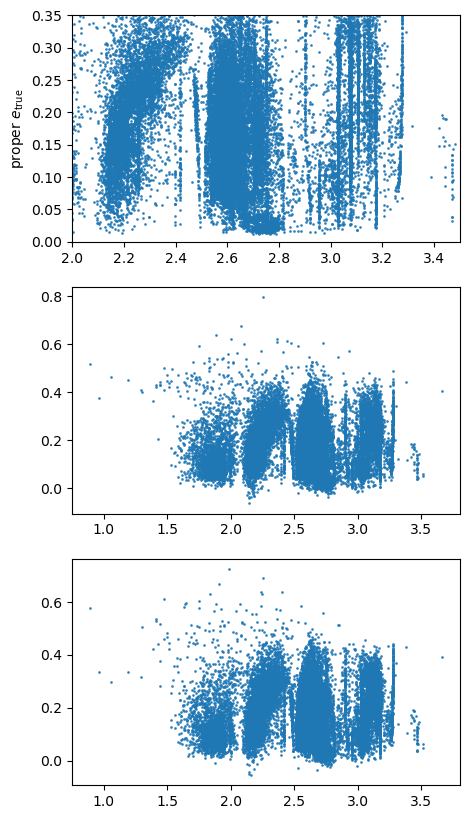

In [ ]:
colors = [
	"red", "blue", "green", "orange", "purple", "brown",
	"pink", "olive", "cyan", "magenta"
]
fig,ax = plt.subplots(3, 1, figsize=(5, 10))
# merged_df_high = merged_df[merged_df['d'] > 100]
df_xgb_high = df_xgb[df_xgb['d'] > 100]
df_ngb_high = df_ngb[df_ngb['d'] > 100]

# linear_prop_e = merged_df_high['prope']
# a = merged_df_high['propa']
# plt.scatter(a, linear_prop_e, s = 1, alpha = 0.2, color = "grey")
ax[0].scatter(df_xgb_high['propa'], df_xgb_high["prope"], alpha = 0.8, s = 1)
ax[1].scatter(df_xgb_high['propa'], df_xgb_high["pred_xgb"] + df_xgb_high["e"], alpha = 0.8, s = 1)
ax[2].scatter(df_ngb_high['propa'], df_ngb_high["pred_e"] + df_ngb_high["e"], alpha = 0.8, s = 1)
labels = ["proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"]
for i in range(3):
	ax[i].set_ylim(0, 0.35)
	ax[i].set_xlim(2, 3.5)
	ax[i].set_ylabel(labels[i])
	for (label, a_val), color in zip(a_values.items(), colors):
		ax[i].vlines(a_val, 0, 0.35, label = label, color = color)
plt.xlabel("proper semi-major axis")
# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import corner

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_576637/1944336075.py:15: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "osculating e", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_576637/1944336075.py:15: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "osculating e", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_576637/1944336075.py:15: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "osculatin

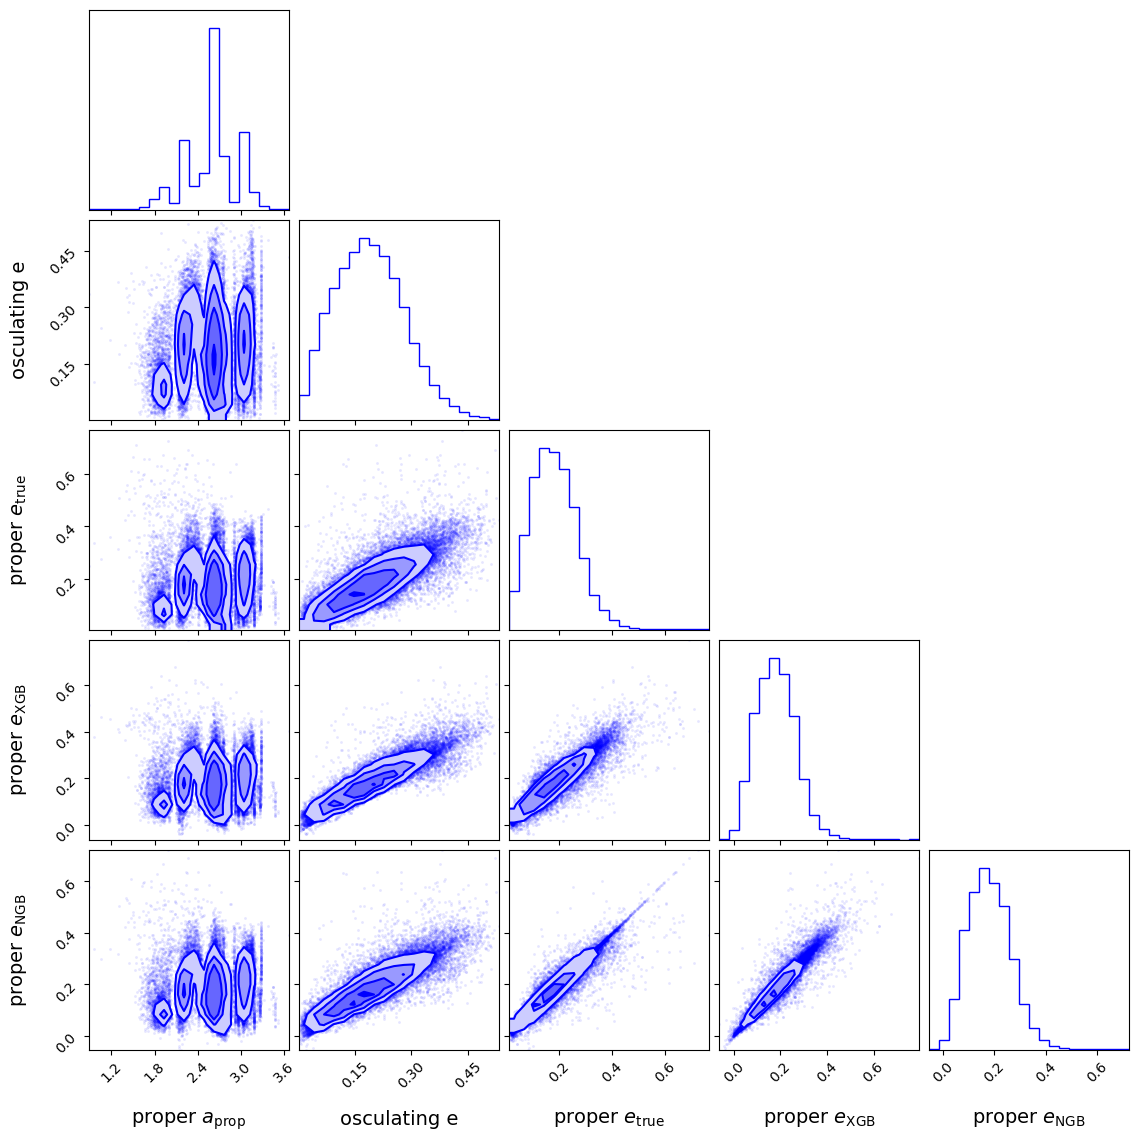

In [ ]:
import matplotlib.pyplot as plt
import corner
import pandas as pd

df_combined = pd.DataFrame({
	'propa': df_xgb_high['propa'],
	'e': df_xgb_high['e'], 
	'true_e': df_xgb_high['prope'],
	'xgb_e': df_xgb_high['pred_xgb'] + df_xgb_high['e'],
	'ngb_e': df_ngb_high['pred_e'] + df_ngb_high['e']
})

figure = corner.corner(
	df_combined,
	labels=["proper $a_{\mathrm{prop}}$", "osculating e", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"],
	plot_contours=True,
	fill_contours=True,
	color="blue",
	label_kwargs={"fontsize": 14},
	title_kwargs={"fontsize": 12},
)

plt.show()


In [40]:
df_ngb_high

,Unnamed: 0,actual_dele,pred_e,error_e,actual_delsini,pred_inc,error_inc,Des'n,e,Incl.,propa,prope,prope_h,propsini,propsini_h,da,dsini,de,d
0,0,0.000067,-0.026765,0.004526,-0.002757,-0.003813,0.000843,h2457,0.023071,5.98580,2.737673,0.023138,0.015653,0.101525,0.050919,2.000000e-08,0.00120,0.0053,139.340444
4,4,-0.038788,-0.049146,0.002846,-0.003989,-0.002819,0.001798,O8107,0.262128,6.03518,2.224343,0.223340,0.211611,0.101150,0.045614,9.700000e-03,0.00180,0.0056,193.952083
10,10,0.005700,0.005272,0.002695,-0.031493,-0.026976,0.003716,K21L39F,0.226565,18.41834,3.105920,0.232265,0.200252,0.284460,0.155587,4.300000e-04,0.00099,0.0051,125.094935
14,14,0.059623,0.025169,0.010408,0.015109,0.013945,0.000554,O9519,0.088359,7.22646,2.680473,0.147982,0.116957,0.140900,0.064980,5.000000e-04,0.00046,0.0210,544.333042
26,26,-0.056714,-0.049326,0.001898,0.014761,0.012707,0.001565,~019B,0.424539,2.48915,2.744898,0.367825,0.395232,0.058191,0.021921,1.300000e-03,0.00065,0.0053,137.074238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499494,499494,-0.011180,-0.010266,0.000781,0.014301,0.014246,0.001111,K16R59J,0.101650,14.99823,2.028066,0.090470,0.227147,0.273090,0.180400,1.400000e-05,0.01100,0.0078,401.735266
499523,499523,0.159123,0.153980,0.004878,-0.006944,-0.008776,0.001617,K21T96M,0.157713,27.40785,3.147037,0.316836,0.120458,0.453377,0.238104,3.900000e-04,0.00220,0.0300,719.405125
499525,499525,0.047851,0.036288,0.008167,0.024058,0.020963,0.003009,K14DG5A,0.094050,4.86325,3.076732,0.141901,0.126507,0.108836,0.047778,9.900000e-04,0.00210,0.0062,158.450827
499528,499528,-0.016498,-0.012869,0.006530,0.012672,0.015257,0.003417,K08AD1S,0.089252,3.71427,2.541128,0.072754,0.075434,0.077453,0.033078,2.800000e-06,0.00056,0.0065,173.636955


In [48]:
df_ngb_high

,Unnamed: 0,actual_dele,pred_e,error_e,actual_delsini,pred_inc,error_inc,Des'n,e,Incl.,propa,prope,prope_h,propsini,propsini_h,da,dsini,de,d
0,0,0.000067,-0.026765,0.004526,-0.002757,-0.003813,0.000843,h2457,0.023071,5.98580,2.737673,0.023138,0.015653,0.101525,0.050919,2.000000e-08,0.00120,0.0053,139.340444
4,4,-0.038788,-0.049146,0.002846,-0.003989,-0.002819,0.001798,O8107,0.262128,6.03518,2.224343,0.223340,0.211611,0.101150,0.045614,9.700000e-03,0.00180,0.0056,193.952083
10,10,0.005700,0.005272,0.002695,-0.031493,-0.026976,0.003716,K21L39F,0.226565,18.41834,3.105920,0.232265,0.200252,0.284460,0.155587,4.300000e-04,0.00099,0.0051,125.094935
14,14,0.059623,0.025169,0.010408,0.015109,0.013945,0.000554,O9519,0.088359,7.22646,2.680473,0.147982,0.116957,0.140900,0.064980,5.000000e-04,0.00046,0.0210,544.333042
26,26,-0.056714,-0.049326,0.001898,0.014761,0.012707,0.001565,~019B,0.424539,2.48915,2.744898,0.367825,0.395232,0.058191,0.021921,1.300000e-03,0.00065,0.0053,137.074238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499494,499494,-0.011180,-0.010266,0.000781,0.014301,0.014246,0.001111,K16R59J,0.101650,14.99823,2.028066,0.090470,0.227147,0.273090,0.180400,1.400000e-05,0.01100,0.0078,401.735266
499523,499523,0.159123,0.153980,0.004878,-0.006944,-0.008776,0.001617,K21T96M,0.157713,27.40785,3.147037,0.316836,0.120458,0.453377,0.238104,3.900000e-04,0.00220,0.0300,719.405125
499525,499525,0.047851,0.036288,0.008167,0.024058,0.020963,0.003009,K14DG5A,0.094050,4.86325,3.076732,0.141901,0.126507,0.108836,0.047778,9.900000e-04,0.00210,0.0062,158.450827
499528,499528,-0.016498,-0.012869,0.006530,0.012672,0.015257,0.003417,K08AD1S,0.089252,3.71427,2.541128,0.072754,0.075434,0.077453,0.033078,2.800000e-06,0.00056,0.0065,173.636955


<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_576637/3462666910.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Linear predicted $\mathrm{e_{prop}}$", fontsize=14)
/tmp/ipykernel_576637/3462666910.py:43: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("XGBoost predicted $\mathrm{e_{prop}}$", fontsize=14)
/tmp/ipykernel_576637/3462666910.py:45: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("NGBoost predicted $\mathrm{e_{prop}}$", fontsize=14)


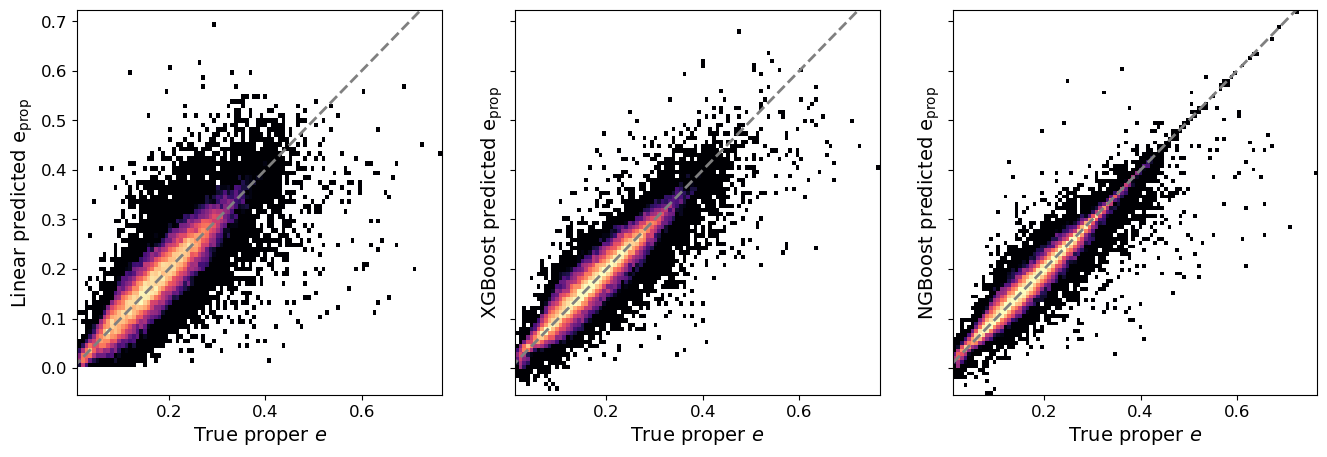

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl

df_combined = pd.DataFrame({
	'propa': df_xgb_high['propa'],
	'e': df_xgb_high['e'], 
	'true_e': df_ngb_high['prope'],
	'linear_e': df_ngb_high['prope_h'],
	'xgb_e': df_xgb_high['pred_xgb'] + df_xgb_high['e'],
	'ngb_e': df_ngb_high['pred_e'] + df_ngb_high['e'],
})

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
bins = 100
vmin = 10
cmap = mpl.cm.magma
norm = LogNorm(vmin=vmin)

data = [
	(df_combined['true_e'], df_combined['linear_e'], "Linear"),
	(df_combined['true_e'], df_combined['xgb_e'], "XGB model"),
	(df_combined['true_e'], df_combined['ngb_e'], "NGB model"),
]

for i, (x, y, label) in enumerate(data):
	ax = axs[i]
	mask = (x <= 1) & (y <= 1)
	x = x[mask]
	y = y[mask]
	h = ax.hist2d(x, y, bins=bins, norm=norm, cmap=cmap)

	minval = min(x.min(), y.min())
	maxval = max(x.max(), y.max())
	ax.plot([minval, maxval], [minval, maxval], ls = 'dashed', linewidth=2, color = "grey")
	ax.set_xlabel("True proper $e$", fontsize=14)
	
	if i == 0:
		ax.set_ylabel("Linear predicted $\mathrm{e_{prop}}$", fontsize=14)
	elif i == 1:
		ax.set_ylabel("XGBoost predicted $\mathrm{e_{prop}}$", fontsize=14)
	else:
		ax.set_ylabel("NGBoost predicted $\mathrm{e_{prop}}$", fontsize=14)

	ax.tick_params(axis='both', labelsize=12)
	h_vals, xedges, yedges = np.histogram2d(x, y, bins=bins)
	X, Y = np.meshgrid((xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import corner
import pandas as pd

df_combined = pd.DataFrame({
	'propa': df_xgb_high['propa'],
	'sini': np.sin(df_xgb_high['Incl.'] * np.pi/180), 
	'true_e': df_xgb_high['prope'],
	'xgb_e': df_xgb_high['pred_xgb'] + df_xgb_high['e'],
	'ngb_e': df_ngb_high['pred_e'] + df_ngb_high['e']
})

figure = corner.corner(
	df_combined,
	labels=["proper $a_{\mathrm{prop}}$", "osculating e", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{XGB}}$", "proper $e_{\mathrm{NGB}}$"],
	plot_contours=True,
	fill_contours=True,
	color="blue",
	label_kwargs={"fontsize": 14},
	title_kwargs={"fontsize": 12},
)

plt.show()

In [ ]:
FN_df_ngb

,Unnamed: 0,actual_dele,pred_ngb,error_ngb,e,propa,prope,propsini,da,dsini,de,d
0,0,0.000067,-0.026765,0.004526,0.023071,2.737673,0.023138,0.101525,2.000000e-08,1.200000e-03,0.005300,139.340444
4,4,-0.038788,-0.049146,0.002846,0.262128,2.224343,0.223340,0.101150,9.700000e-03,1.800000e-03,0.005600,193.952083
9,9,-0.032743,-0.022481,0.001442,0.068595,3.183672,0.035852,0.204853,8.400000e-06,1.700000e-07,0.000004,0.107343
14,14,0.059623,0.025169,0.010408,0.088359,2.680473,0.147982,0.140900,5.000000e-04,4.600000e-04,0.021000,544.333042
30,30,-0.038755,-0.065407,0.011197,0.205466,2.564699,0.166711,0.029090,1.800000e-06,8.400000e-04,0.004400,118.670871
...,...,...,...,...,...,...,...,...,...,...,...,...
499479,499479,-0.013180,-0.001164,0.011313,0.109596,2.570844,0.096416,0.039245,8.500000e-07,1.500000e-03,0.005100,140.664488
499490,499490,-0.029117,-0.016459,0.010346,0.086708,2.543419,0.057591,0.041427,7.400000e-07,5.600000e-06,0.001300,34.583957
499510,499510,-0.010007,-0.001753,0.006426,0.155434,3.023461,0.145427,0.178807,4.500000e-05,8.200000e-05,0.000580,14.295430
499516,499516,-0.031395,-0.023326,0.010156,0.063551,2.789101,0.032156,0.109664,1.400000e-07,2.900000e-04,0.000980,25.963208


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_179667/3440616731.py:22: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_179667/3440616731.py:22: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_179667/3440616731.py:22: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_179667/3440616731.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN_df_xgb_high = FN_df_xg

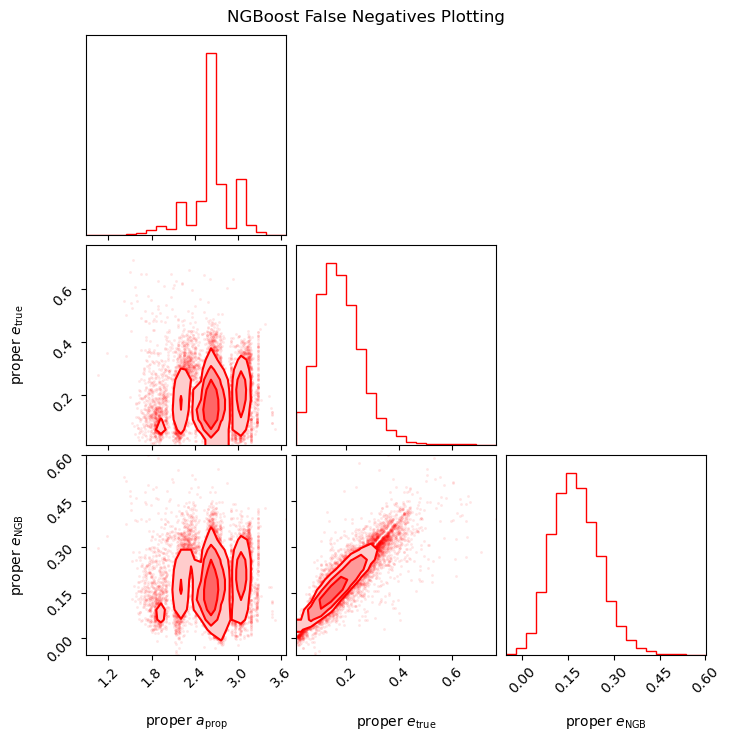

In [ ]:
import matplotlib.pyplot as plt
import corner
import pandas as pd

FN_df_xgb_high = FN_df_xgb[df_xgb['d'] > 100]
FN_df_ngb_high = FN_df_ngb[df_ngb['d'] > 100]
FN_df_ngb_high["diff_threshold"] = (FN_df_ngb_high['e'] + FN_df_ngb_high['pred_ngb']) - actual_threshold

ecc_dist_abs = np.abs(FN_df_ngb_high["diff_threshold"])
normalized_alpha = (ecc_dist_abs - ecc_dist_abs.min()) / (ecc_dist_abs.max() - ecc_dist_abs.min())
normalized_alpha = 0.1 + 0.9 * normalized_alpha

df_combined = pd.DataFrame({
	'propa': FN_df_ngb_high['propa'],
	'true_e': FN_df_ngb_high['prope'],
	# 'xgb_e': FN_df_xgb_high['pred_xgb'] + FN_df_xgb_high['e'],
	'ngb_e': FN_df_ngb_high['pred_ngb'] + FN_df_ngb_high['e']
})

figure = corner.corner(
	df_combined,
	labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
	plot_contours=True,
	fill_contours=True,
	color="red"
)

figure.suptitle("NGBoost False Negatives Plotting")

plt.show()


In [21]:
FN_df_ngb_high["diff_threshold"]

0        -0.007469
14        0.108430
30             NaN
113       0.197869
242       0.120302
            ...   
499426         NaN
499443    0.228026
499452    0.144945
499479    0.116024
499525    0.112227
Name: diff_threshold, Length: 17209, dtype: float64

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_179667/1687107751.py:21: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_179667/1687107751.py:21: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
/tmp/ipykernel_179667/1687107751.py:21: SyntaxWarning: invalid escape sequence '\m'
  labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],


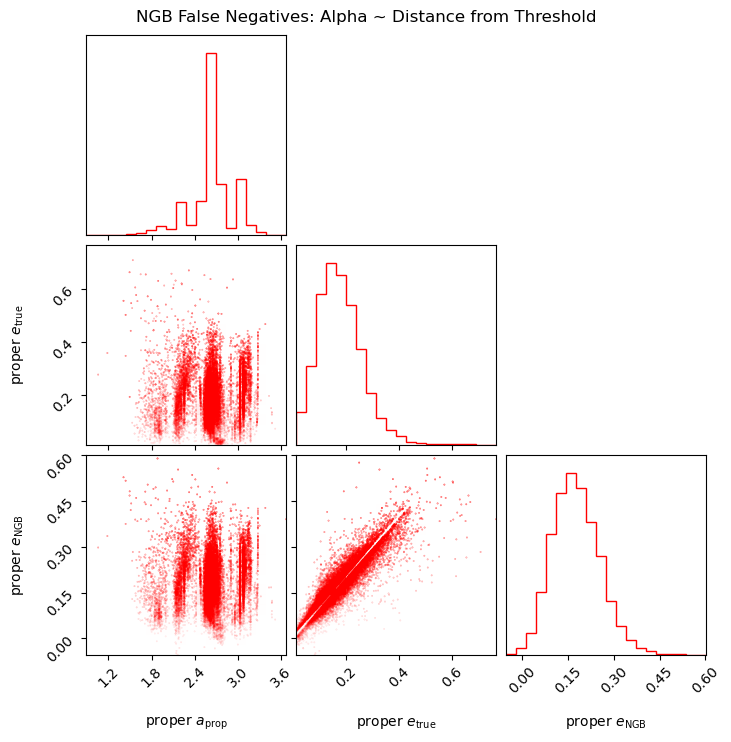

In [ ]:
import matplotlib.pyplot as plt
import corner
import pandas as pd
import numpy as np

FN_df_ngb_high = FN_df_ngb[FN_df_ngb['d'] > 100].copy()
FN_df_ngb_high["diff_threshold"] = (FN_df_ngb_high['e'] + FN_df_ngb_high['pred_ngb']) - actual_threshold

ecc_dist_abs = np.abs(FN_df_ngb_high["diff_threshold"])
normalized_alpha = (ecc_dist_abs - ecc_dist_abs.min()) / (ecc_dist_abs.max() - ecc_dist_abs.min())
normalized_alpha = 0.1 + 0.9 * normalized_alpha

df_combined = pd.DataFrame({
	'propa': FN_df_ngb_high['propa'],
	'true_e': FN_df_ngb_high['prope'],
	'ngb_e': FN_df_ngb_high['pred_ngb'] + FN_df_ngb_high['e']
})

figure = corner.corner(
	df_combined,
	labels=["proper $a_{\mathrm{prop}}$", "proper $e_{\mathrm{true}}$", "proper $e_{\mathrm{NGB}}$"],
	plot_contours=False,
	fill_contours=False,
	color="red",
	plot_datapoints=False
)

axes = np.array(figure.axes).reshape((3, 3))
cols = df_combined.columns

for i in range(3):
	for j in range(i):
		ax = axes[i, j]
		x = df_combined[cols[j]]
		y = df_combined[cols[i]]
		ax.scatter(x, y, color='red', alpha=normalized_alpha, s=0.1)

figure.suptitle("NGB False Negatives: Alpha ~ Distance from Threshold")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import corner
import pandas as pd

# Step 1: Filter the data
df_xgb_high = df_xgb[df_xgb['d'] > 100].copy()
df_ngb_high = df_ngb[df_ngb['d'] > 100].copy()

# Step 2: Construct a combined DataFrame for corner plot
df_combined = pd.DataFrame({
	'propa': df_xgb_high['propa'],
	'true_e': df_xgb_high['prope'],
	'xgb_e': df_xgb_high['pred_xgb'] + df_xgb_high['e'],
	'ngb_e': df_ngb_high['pred_ngb'] + df_ngb_high['e']
})

# Step 3: Make the corner plot
figure = corner.corner(
	df_combined,
	labels=["$a_{\mathrm{prop}}$", "$e_{\mathrm{true}}$", "$e_{\mathrm{XGB}}$", "$e_{\mathrm{NGB}}$"],
	show_titles=True,
	title_fmt=".3f",
	plot_contours=False,
	color="blue",
	label_kwargs={"fontsize": 12},
	title_kwargs={"fontsize": 10}
)

plt.show()

In [ ]:
colors = [
	"red", "blue", "green", "orange", "purple", "brown",
	"pink", "olive", "cyan", "magenta"
]

merged_df_high = merged_df[merged_df['d'] > 100]
FN_df_high = FN_df[FN_df['d'] > 100]
linear_prop_e = merged_df_high['prope']
e = merged_df_high['e']
a = merged_df_high['propa']
plt.scatter(a, linear_prop_e, s = 1, alpha = 0.2, color = "grey")

for (label, a_val), color in zip(a_values.items(), colors):
	plt.vlines(a_val, 0, 0.35, label = label, color = color)
plt.ylim(0, 0.35)
plt.xlim(2, 3.5)
plt.xlabel("proper semi-major axis")
plt.ylabel("proper eccentricity")
plt.legend()
plt.tight_layout()
plt.show()

["Des'n",
 'H_x',
 'G',
 'Epoch',
 'M',
 'Peri.',
 'Node',
 'Incl.',
 'e',
 'n',
 'a',
 'propa',
 'da',
 'prope',
 'de',
 'propsini',
 'dsini',
 'g',
 's',
 'H_y',
 'NumOpps',
 'prope_h',
 'propsini_h',
 'g0',
 'ecospo',
 'esinpo',
 'sinicosO',
 'sinisinO',
 'd']

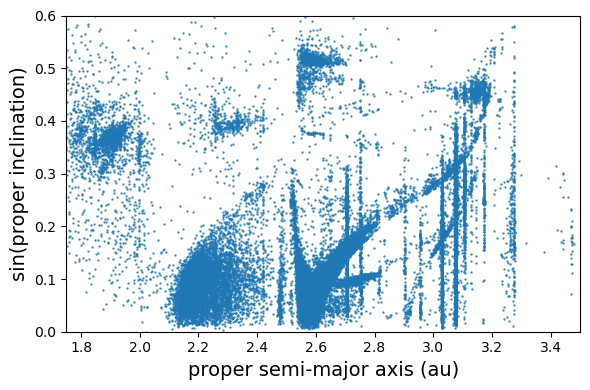

In [31]:
df_xgb_high = df_xgb[df_xgb['d'] > 100]
df_ngb_high = df_ngb[df_ngb['d'] > 100]
# merged_df_high = merged_df[merged_df['d'] > 100]
# linear_prop_inc = np.sin(merged_df_high['propsini'])
# a = merged_df_high['propa']
plt.figure(figsize = [6, 4])
# plt.scatter(a, linear_prop_inc, s = 1, alpha = 0.1)
# plt.scatter(FN_df_high['propa'], np.sin(FN_df_high['propsini']), color = 'red', alpha = 0.8, s = 1, label = "False Negative Asteroids", rasterized=True)
plt.scatter(df_ngb_high['propa'], df_ngb_high["pred_inc"] + np.sin(df_ngb_high["Incl."] * np.pi/180), alpha = 0.8, s = 0.5)
# ax[1].scatter(df_xgb_high['propa'], df_xgb_high["pred_xgb"] + df_xgb_high["e"], alpha = 0.8, s = 1)
# ax[2].scatter(df_ngb_high['propa'], df_ngb_high["pred_ngb"] + df_ngb_high["e"], alpha = 0.8, s = 1)
# labels = ["proper eccentricity", "xgb wt crepes proper eccentricity", "ngb proper eccentricity"]
# for i in range(3):
# 	ax[i].set_ylim(0, 0.35)
# 	ax[i].set_xlim(2, 3.5)
# 	ax[i].set_ylabel(labels[i])
plt.ylim(0, 0.6)
plt.xlim(1.75, 3.5)
# for (label, a_val), color in zip(a_values.items(), colors):
#     plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.xlabel("proper semi-major axis (au)", size = 14)
plt.ylabel("sin(proper inclination)", size = 14)
plt.tight_layout()
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_188661/2876374596.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sqrt{e^2 + (sin (i))^2}$", size = 17)


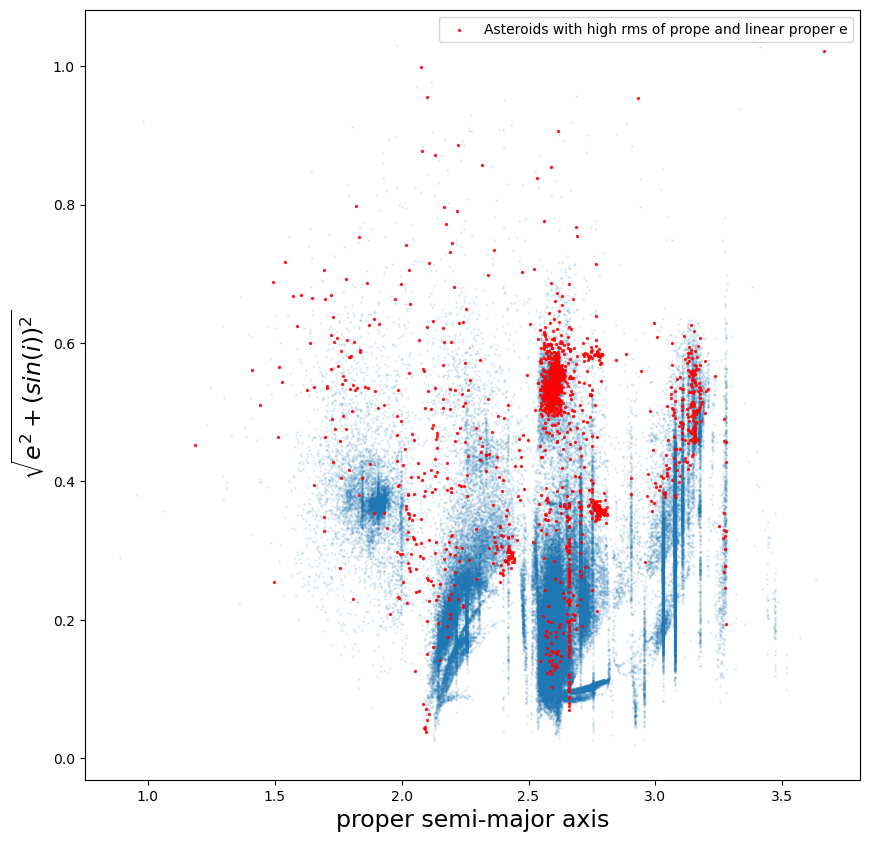

In [137]:
merged_df_high = merged_df[merged_df['d'] > 100]
para_e_inc = np.sqrt(np.sin(merged_df_high['propsini'])**2 + merged_df_high['prope']**2)
a = merged_df_high['propa']
plt.figure(figsize=[10, 10])
plt. scatter(a, para_e_inc, s = 1, alpha = 0.1)
plt.scatter(high_error_asteroids['propa'], np.sqrt(np.sin(high_error_asteroids['propsini'])**2 + high_error_asteroids['prope']**2), color = 'red', alpha = 0.8, s = 2, label = "Asteroids with high rms of prope and linear proper e")
# plt.ylim(0, 0.3)
# plt.xlim(1.75, 3.5)
# for (label, a_val), color in zip(a_values.items(), colors):
#     plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.xlabel("proper semi-major axis", size = 17)
plt.ylabel("$\sqrt{e^2 + (sin (i))^2}$", size = 17)
plt.legend()
plt.tight_layout
plt.show()

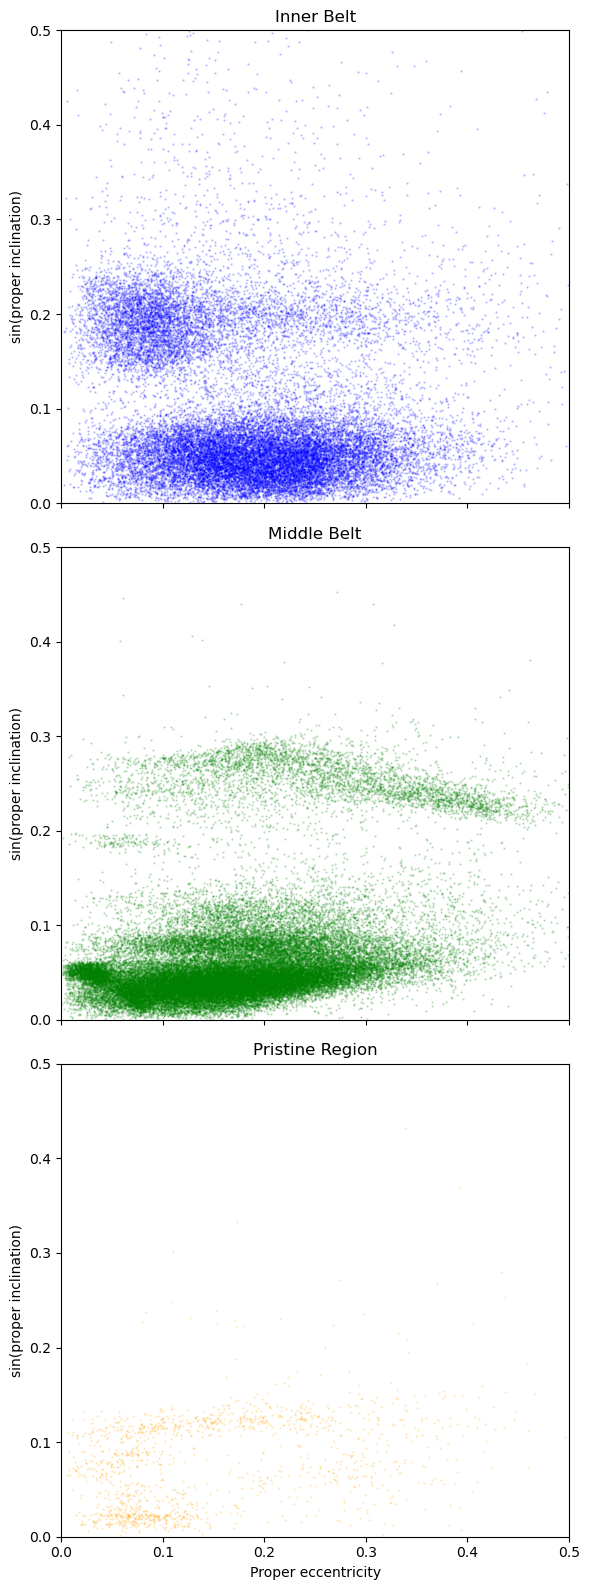

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

inner_belt_df = merged_df_high[merged_df_high["propa"] < 2.5]
middle_belt_df = merged_df_high[(merged_df_high["propa"] > 2.5) & (merged_df_high["propa"] < 2.825)]
pristine_df = merged_df_high[(merged_df_high["propa"] > 2.825) & (merged_df_high["propa"] < 2.958)]

fig, ax = plt.subplots(3, 1, figsize=(6, 16), sharex=True, sharey=True)

# Inner belt
linear_sin_i_inner = np.sin(inner_belt_df['propsini_h'])
linear_prope_inner = inner_belt_df["prope_h"]
ax[0].scatter(linear_prope_inner, linear_sin_i_inner, s=0.5, alpha=0.2, color='blue')
ax[0].set_title("Inner Belt")

# Middle belt
linear_sin_i_middle = np.sin(middle_belt_df['propsini_h'])
linear_prope_middle = middle_belt_df["prope_h"]
ax[1].scatter(linear_prope_middle, linear_sin_i_middle, s=0.5, alpha=0.2, color='green')
ax[1].set_title("Middle Belt")

# Pristine region
linear_sin_i_pristine = np.sin(pristine_df['propsini_h'])
linear_prope_pristine = pristine_df["prope_h"]
ax[2].scatter(linear_prope_pristine, linear_sin_i_pristine, s=0.5, alpha=0.2, color='orange')
ax[2].set_title("Pristine Region")

for axis in ax:
	axis.set_xlim(0, 0.5)
	axis.set_ylim(0, 0.5)
	axis.set_ylabel("sin(proper inclination)")

ax[2].set_xlabel("Proper eccentricity")

plt.tight_layout()
plt.show()

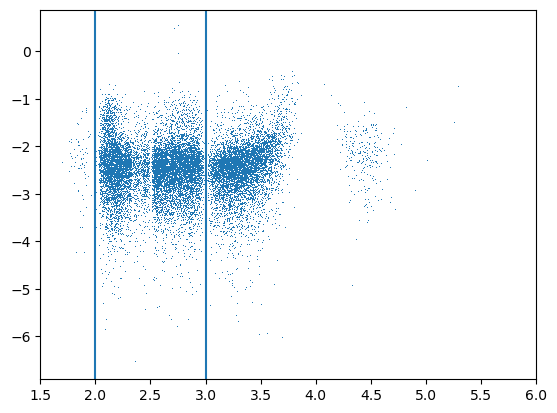

In [ ]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

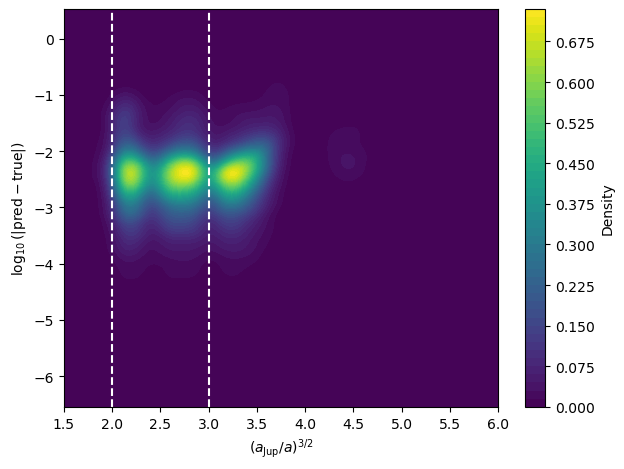

In [ ]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()

# Transform the d into e measurement

In [ ]:
from astropy.constants import au
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hcm_cut_1 = [
	80, 70, 40, 30, 70, 20, 80, 70, 20, 50,
	40, 30, 65, 10, 20, 50, 30, 60, 25, 100,
	60, 10, 30, 40, 20, 20, 20, 20, 20, 30, 15
]

hcm_cut_2 = [
	30, 35, 60, 50, 40, 60, 20, 20, 50, 40,
	37, 40, 20, 20, 40, 60, 30, 50, 35, 20,
	30, 50, 55, 58, 10, 30, 20, 10, 10, 50,
	20, 30, 7, 20, 15, 10, 10, 40, 20, 40,
	30, 20, 50, 50, 30, 20, 20, 60, 10, 40,
	50, 10, 15, 50, 50, 50, 90, 50, 60, 90,
	50, 60, 70, 40
]

hcm_cut_3 = [50, 55, 70, 50, 70, 10, 30, 60, 30, 20,
		   50, 30, 30, 40, 25, 30, 22, 15, 10, 20,
		   20, 30, 80, 10, 40, 100, 18, 10, 20, 20,
		   40, 60, 20, 60, 45, 30, 10, 30, 30]
a_1 = 2.2
a_2 = 2.7
a_3 = 3.4

In [2]:
au.value

np.float64(149597870700.0)

In [ ]:
width = []
for i in range(len(hcm_cut_1)):
	width.append(hcm_cut_1[i] * np.sqrt(a_1) / (3 * 1e4 * np.sqrt(2)))
	
for i in range(len(hcm_cut_2)):
	width.append(hcm_cut_2[i] * np.sqrt(a_2) / (3 * 1e4 * np.sqrt(2)))
	
for i in range(len(hcm_cut_3)):
	width.append(hcm_cut_3[i] * np.sqrt(a_3) / (3 * 1e4 * np.sqrt(2)))
width

[np.float64(0.002796823595120404),
 np.float64(0.0024472206457303533),
 np.float64(0.001398411797560202),
 np.float64(0.0010488088481701515),
 np.float64(0.0024472206457303533),
 np.float64(0.000699205898780101),
 np.float64(0.002796823595120404),
 np.float64(0.0024472206457303533),
 np.float64(0.000699205898780101),
 np.float64(0.0017480147469502525),
 np.float64(0.001398411797560202),
 np.float64(0.0010488088481701515),
 np.float64(0.002272419171035328),
 np.float64(0.0003496029493900505),
 np.float64(0.000699205898780101),
 np.float64(0.0017480147469502525),
 np.float64(0.0010488088481701515),
 np.float64(0.002097617696340303),
 np.float64(0.0008740073734751263),
 np.float64(0.003496029493900505),
 np.float64(0.002097617696340303),
 np.float64(0.0003496029493900505),
 np.float64(0.0010488088481701515),
 np.float64(0.001398411797560202),
 np.float64(0.000699205898780101),
 np.float64(0.000699205898780101),
 np.float64(0.000699205898780101),
 np.float64(0.000699205898780101),
 np.floa

Text(0, 0.5, "Number of Asteroids' families")

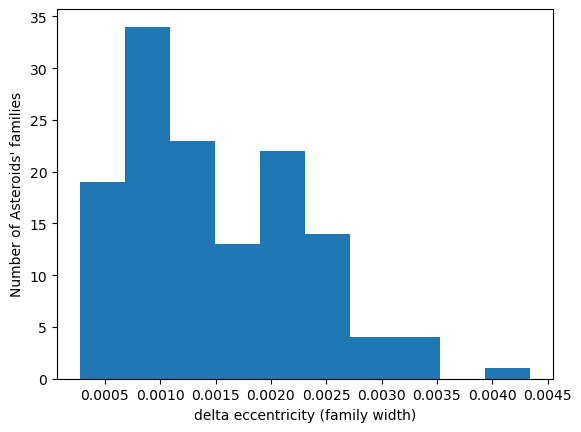

In [5]:
plt.hist(width)
plt.xlabel("delta eccentricity (family width)")
plt.ylabel("Number of Asteroids' families")

(0.0, 0.3)

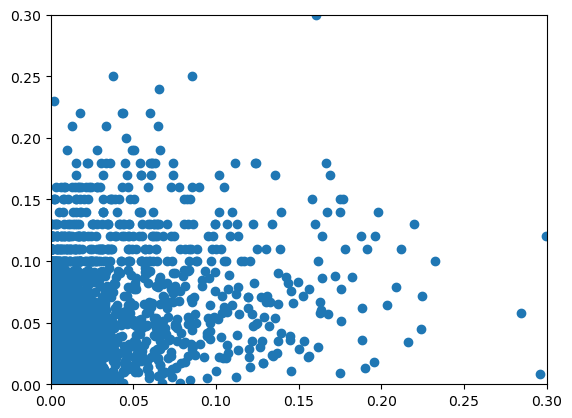

In [19]:
import matplotlib.pyplot as plt
plt.scatter(merged_df["da"]/merged_df["propa"], merged_df["de"])
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)